<h1 style="text-align: center; font-size:2.5em;"> Assignment 2 </h1>

# <u> Part 1: Twitter Network Analysis</u>

### <i> Exercise 1: Build the network of retweets.</i>

We will now build a network that has as nodes the Twitter handles of the members of the house, and direct edges between nodes A and B if A has retweeted content posted by B. We will build a weighted network, where the weight of an edge is equal to the number of retweets.

In [1]:
import networkx as nx
import pandas as pd
import os
import re
import io

- First, we go through all the files (provided in the Repository of the course) and add a node per congressman.

In [2]:
path = 'data/tweets/'

#Directed graph
rt_graph = nx.DiGraph()

#Undirected graph.
#Useful in future exercises
rt_nonDirgraph = nx.Graph()

#Relation Twitter profile to Party
tw_parties = pd.read_csv('./data/H115_tw.csv')

for file in os.listdir(path):
    # Include the member we are analysing to the network
    rt_graph.add_node(file,
                      party=tw_parties[tw_parties.tw_name == file].Party,
                      betrayals=0 #rt to other party
                     )
    #Include nodes in non directed graph for future exercises
    rt_nonDirgraph.add_node(file,
                      party=tw_parties[tw_parties.tw_name == file].Party,
                      betrayals=0)

- Using the nodes in the network we just created, we look for the retweets each of them has performed using a regular expression.
- Once all retweets are located, we add the corresponding edges in the network.

In [3]:
for acc in rt_graph.nodes:
    f = io.open(path+acc, 'r', encoding='utf-8').read()
    
    #We find all his RTs
    rts = re.findall(r"(RT)((?:\b\W@(\w+))+)", f)
    
    for rt in rts:
        original = rt[2] #we only get the user name
        if original in rt_graph.nodes: #if it is a member
            #check if edge already exists
            if rt_graph.has_edge(acc, original):
                rt_graph[acc][original]['weight'] += 1
            else:
                rt_graph.add_edge(acc,
                                  original,
                                  weight=1)

# removing self loops
rt_graph.remove_edges_from(rt_graph.selfloop_edges())

<hr>

### <i> Exercise 2: Visualize the network of retweets and investigate differences between the parties. </i>

- Using the Networkx draw function and the force atlas algorithm, we can plot the network we built in the previous exercise.

In [4]:
#I need to create de non-directed graph.
#Nodes are already in the network, only need to create the edges.
for acc in rt_nonDirgraph.nodes:
    
    f = io.open(path+acc, 'r', encoding='utf-8').read()
    
    #We find all his RTs
    rts = re.findall(r"(RT)((?:\b\W@(\w+))+)", f)
    
    for rt in rts:
        #we only get the user name
        poster = rt[2]
        if poster in rt_nonDirgraph.nodes: #if it is a member
            #check if edge already exists
            if rt_nonDirgraph.has_edge(acc, poster):
                rt_nonDirgraph[acc][poster]['weight'] += 1
                #print(rt_graph[acc][poster]['weight'])
            else:
                #new edge created
                rt_nonDirgraph.add_edge(acc,
                                  poster,
                                  weight=1)

100%|██████████| 8000/8000 [00:21<00:00, 371.27it/s]


BarnesHut Approximation  took  6.24  seconds
Repulsion forces  took  13.13  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.17  seconds
AdjustSpeedAndApplyForces step  took  0.92  seconds


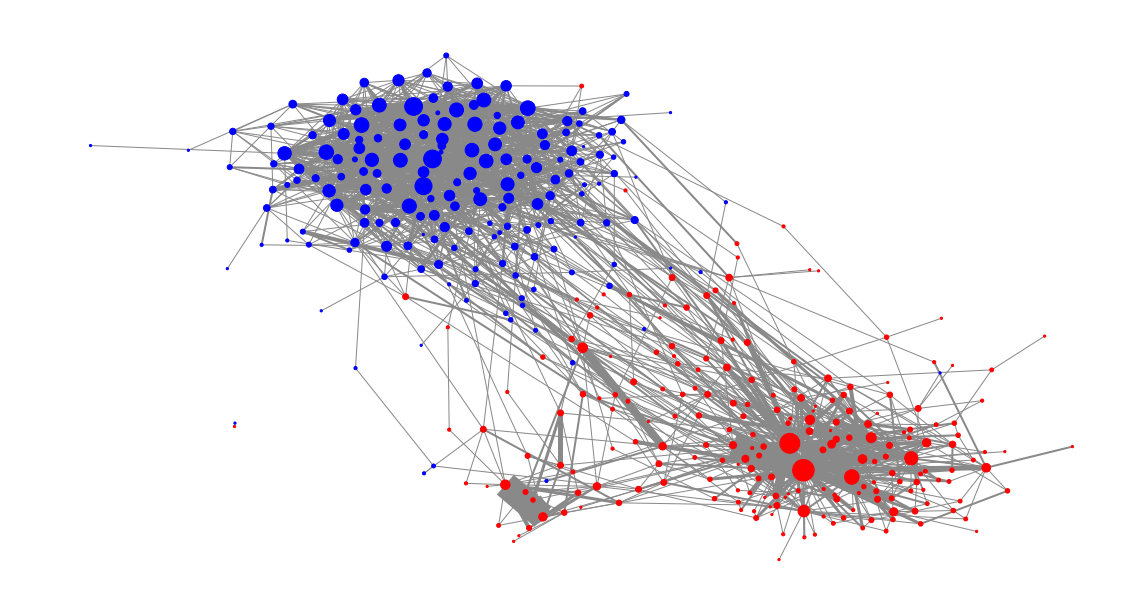

In [29]:
import fa2
import matplotlib.pyplot as plt

forceatlas2 = fa2.ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=0,

    # Performance
    jitterTolerance=.01,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio= 1,
    strongGravityMode=True,
    gravity=200,
    # Log
    verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(rt_nonDirgraph,
                                                    pos=None,
                                                    iterations=8000);

#We use this list to ease the coloring of nodes according to parties
rep = list()
for node in rt_nonDirgraph:
    if rt_nonDirgraph.node[node]['party'].item() == 'Republican':
        rep.append(node)

#List with node as key and its degree as value
degrees = {}
for node, degree in nx.degree(rt_graph):
    degrees[node] = degree

#Set node color acording to its party
node_colors = ["red" if n in rep
               else 'blue' for n in rt_nonDirgraph.nodes()]

#List of weights using edge as key
weights = {}
for u, v in rt_nonDirgraph.edges:
    weights[(u, v)] = rt_nonDirgraph[u][v]['weight']
    
plt.rcParams["figure.figsize"] = [15, 8];  
nx.draw(rt_nonDirgraph,
        positions,
        cmap=plt.get_cmap('jet'),
        edge_color="#898989",
        #nodelist=degrees.keys(),
        node_size=[v * 5 for v in degrees.values()],
        node_color = node_colors,
        border = .1,
        overlap = False,
         width = [w for w in weights.values()],
#        width = 0.3,
        with_labels=False)

- Compare the network of Retweets with the network of Wikipedia pages (Week 5, exercise 2). Do you observe any difference? How do you explain them?
    - _There are two main differences we find in this network compared to the one using Wikipedia:_
        - _Firstly, some of the nodes are not connected to others. This can be because they never retweeted any content of because their content was retweeted but they are not members of the congress._
        - _Secondly, there as a much clear association of the nodes within their parties. We can see that most of the nodes are connected to members of the same party._

- Now set the nodes' size proportional to their betweenness centrality. What do you observe?
    - _We observe an uneven distribution of centrality._

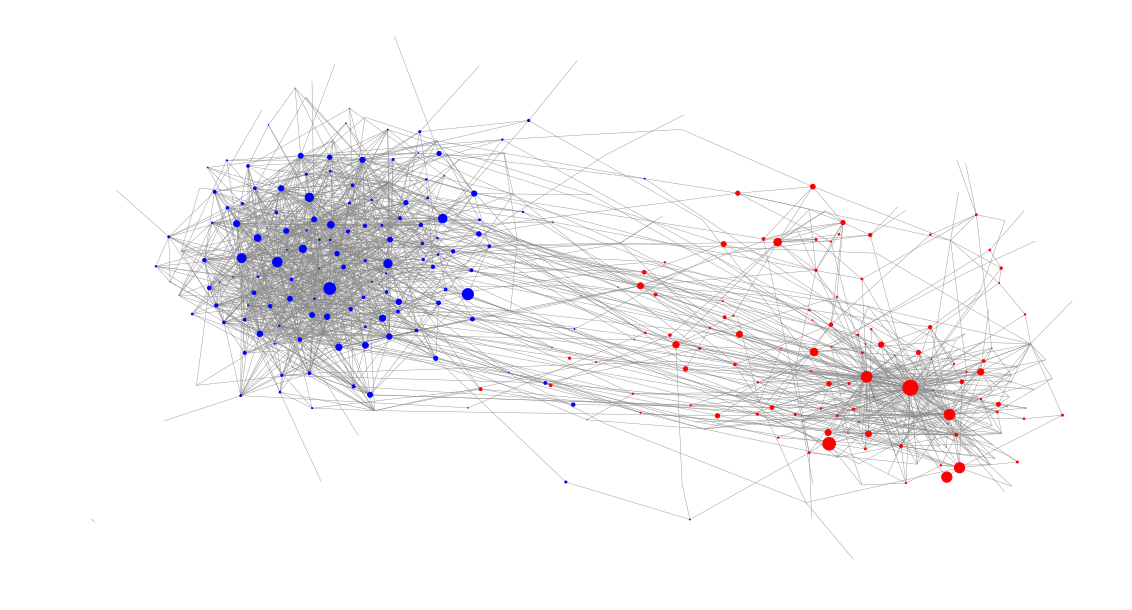

In [6]:
plt.rcParams["figure.figsize"] = [15, 8];

weights = {}
for u, v in rt_nonDirgraph.edges:
    weights[(u, v)] = rt_nonDirgraph[u][v]['weight']
    
nx.draw(rt_nonDirgraph,
        positions,
        cmap=plt.get_cmap('jet'),
        #nodelist=degrees.keys(),
        node_size = [v * 2000 for v in nx.betweenness_centrality(rt_graph).values()],
        node_color = node_colors,
        edge_color="#898989",
        border = 0.1,
        overlap = False,
        width = .4,
        with_labels=False)

- Repeat the point above using eigenvector centrality instead. Is there any difference? Can you explain why?
    - TODO: _NO F IDEA_

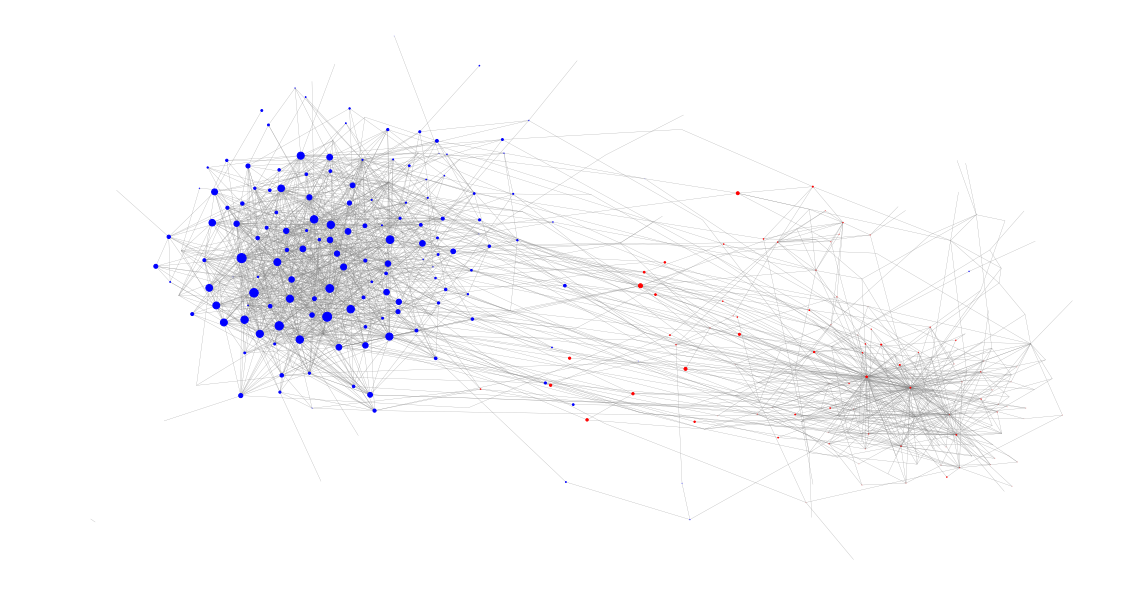

In [7]:
plt.rcParams["figure.figsize"] = [15, 8];

nx.draw(rt_nonDirgraph,
        positions,
        cmap=plt.get_cmap('jet'),
        #nodelist=degrees.keys(),
        node_size = [v * 300 for v in nx.eigenvector_centrality(rt_graph).values()],
        node_color = node_colors,
        border = 0.1,
        edge_color="#898989",
        overlap = False,
        width = .2,
        with_labels=False)

- Who are the three nodes with highest degree within each party? And eigenvector centrality? And betweenness centrality?

    - _We create two lists (one per party) where each of the values inside the lists include a fourplet (node, degree, eigenvector distribution, betweenness distribution)._

In [8]:
rep_deg, dem_deg = [], []

for node in rt_graph.nodes():
    if node in rep:
        rep_deg.append((node,
                        rt_graph.degree(node),
                        nx.eigenvector_centrality(rt_graph, 1000)[node],
                        nx.betweenness_centrality(rt_graph)[node]))
    else:
        dem_deg.append((node,
                        rt_graph.degree(node),
                        nx.eigenvector_centrality(rt_graph, 1000)[node],
                        nx.betweenness_centrality(rt_graph)[node]
                      ))

_We sort the congressmen using the second value (indexed as 1) which is its degree._

In [9]:
top3_deg = sorted(rt_graph.degree(), key=lambda x: x[1], reverse = True)[:3]
top3_deg_rep = sorted(rep_deg, key=lambda x: x[1], reverse = True)[:3]
top3_deg_dem = sorted(dem_deg, key=lambda x: x[1], reverse = True)[:3]

In [10]:
print('Three nodes with highest degree:')
for node in top3_deg:
    print('– ', node[0], ": ", node[1])

print('\nThree republicans with highest degree:')
for node in top3_deg_rep:
    print('– ', node[0], ": ", node[1])

print('\nThree democrats with highest degree:')
for node in top3_deg_dem:
    print('– ', node[0], ": ", node[1])

Three nodes with highest degree:
–  SpeakerRyan :  93
–  SteveScalise :  79
–  NancyPelosi :  63

Three republicans with highest degree:
–  SpeakerRyan :  93
–  SteveScalise :  79
–  GOPLeader :  42

Three democrats with highest degree:
–  NancyPelosi :  63
–  repmarkpocan :  63
–  WhipHoyer :  58


_We do the same using the third and fourth values: eigenvector and betweenness distribution._

In [11]:
top3_eig_rep = sorted(rep_deg, key=lambda x: x[2], reverse = True)[:3]
top3_eig_dem = sorted(dem_deg, key=lambda x: x[2], reverse = True)[:3]
top3_bet_rep = sorted(rep_deg, key=lambda x: x[3], reverse = True)[:3]
top3_bet_dem = sorted(dem_deg, key=lambda x: x[3], reverse = True)[:3]

In [12]:
print('Three republicans with highest eigenvector centrality:')
for node in top3_eig_rep:
    print('– ', node[0], ": ", node[2])
    
print('\nThree democrats with highest eigenvector centrality:')
for node in top3_eig_dem:
    print('– ', node[0], ": ", node[2])

print('\nThree republicans with highest betweenness centrality:')
for node in top3_bet_rep:
    print('– ', node[0], ": ", node[3])

print('\nThree democrats with highest betweenness centrality:')
for node in top3_bet_dem:
    print('– ', node[0], ": ", node[3])

Three republicans with highest eigenvector centrality:
–  RosLehtinen :  0.05314824347623461
–  RepSteveStivers :  0.02954542032696024
–  justinamash :  0.028403717821331043

Three democrats with highest eigenvector centrality:
–  repmarkpocan :  0.2711250612528277
–  RepBeatty :  0.26512107057771106
–  RepCummings :  0.23799435256020762

Three republicans with highest betweenness centrality:
–  SpeakerRyan :  0.11323246961084296
–  PatrickMcHenry :  0.07927652852223582
–  SteveScalise :  0.05662851413708352

Three democrats with highest betweenness centrality:
–  NancyPelosi :  0.06723386821176298
–  RepDavidEPrice :  0.06169886508856411
–  WhipHoyer :  0.045009931292083034


## TODO

- Plot on the same figure the distribution of outgoing strength for the republican and democratic nodes (e.g. the sum of the weight on outgoing links). Which party is more active in retweeting other members of the house?

- Find the 3 members of the republican party that have retweet more often tweets from democratic members. Repeat the measure for the democratic members. Can you explain your results by looking at the Wikipedia pages of these members of the house?

In [13]:
for edge in rt_graph.edges:

    acc = edge[0]
    poster = edge[1]

    if rt_graph.nodes[acc]['party'].item() != rt_graph.nodes[poster]['party'].item():
        rt_graph.nodes[acc]['betrayals'] += 1

In [14]:
betrayers_rep = []
betrayers_dem = []
for node in rt_graph.nodes:
    if rt_graph.nodes[node]['party'].item() == 'Republican':
        betrayers_rep.append((node, rt_graph.nodes[node]['betrayals']))
    else:
        betrayers_dem.append((node, rt_graph.nodes[node]['betrayals']))

In [15]:
top3_betrayers_rep = sorted(betrayers_rep, key=lambda x: x[1], reverse = True)[:3]
top3_betrayers_dem = sorted(betrayers_dem, key=lambda x: x[1], reverse = True)[:3]
print('Top3 republicans who retweeted democrats:')
for node in top3_betrayers_rep:
    print('– ', node[0], ': ', node[1])
print('\nTop3 democrats who retweeted republicans:')
for node in top3_betrayers_dem:
    print('– ', node[0], ': ', node[1])

Top3 republicans who retweeted democrats:
–  RepRyanCostello :  5
–  RepMikeTurner :  4
–  TomRooney :  3

Top3 democrats who retweeted republicans:
–  RepDebDingell :  3
–  RepAnnaEshoo :  2
–  RepCartwright :  2


<hr>

### <i> Exercise 3: Community detection.</i>

- Use your favorite method of community detection to find communities in the full house of representatives network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found for the Wikipedia network? Comment on your result.

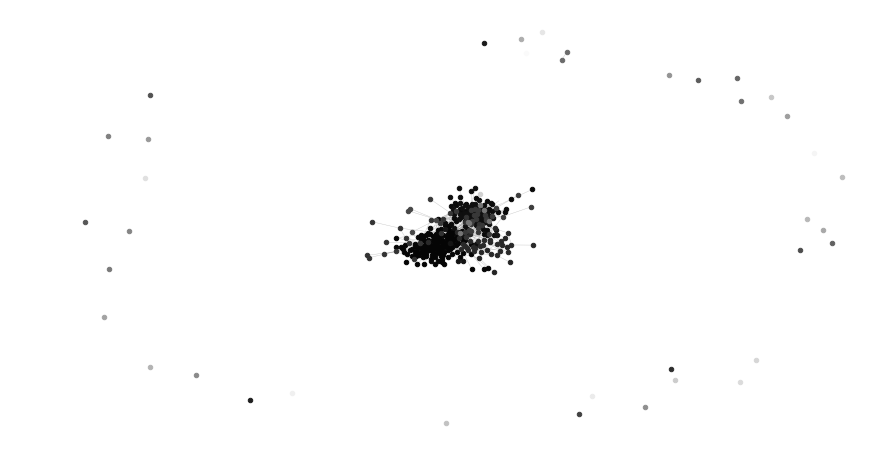

In [16]:
import community
import matplotlib.pyplot as plt

partition = community.best_partition(rt_nonDirgraph)

#drawing
plt.rcParams["figure.figsize"] = [15, 8];
size = float(len(set(partition.values())))
pos = nx.spring_layout(rt_nonDirgraph)
count = 0.
for com in set(partition.values()):
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                  if partition[nodes] == com]
    nx.draw_networkx_nodes(rt_nonDirgraph,
                          pos,
                          list_nodes,
                          node_size = 20,
                          node_color = str(count/size))
nx.draw_networkx_edges(rt_nonDirgraph, pos, alpha=.5, width=.4, edge_color="#898989")
plt.axis('off')
plt.show()

In [17]:
L = len(rt_graph.edges()) #Total amount of edges
L_rep, L_dem = 0, 0

for edge in rt_graph.edges():
    if tw_parties[tw_parties.tw_name == edge[0]].Party.values[0] == tw_parties[tw_parties.tw_name == edge[1]].Party.values[0] == 'Republican':
        L_rep += 1
    elif tw_parties[tw_parties.tw_name == edge[0]].Party.values[0] == tw_parties[tw_parties.tw_name == edge[1]].Party.values[0] == 'Democratic':
        L_dem += 1

K_rep, K_dem = 0, 0
for elt in list(rt_graph.degree()):
    if tw_parties[tw_parties.tw_name == elt[0]].Party.values[0] == 'Republican':
        K_rep += elt[1]
    else:
        K_dem += elt[1]
        
modularity = (L_rep/L - pow(K_rep/(2*L),2)) + (L_dem/L - pow(K_dem/(2*L),2))
print('Modularity = ', modularity)

Modularity =  0.3805350268889932


- Visualize the network, using the Force Atlas algorithm (see Lecture 5, exercise 2). This time assign each node a different color based on their community. Describe the structure you observe.

100%|██████████| 6000/6000 [00:18<00:00, 315.97it/s]


BarnesHut Approximation  took  4.11  seconds
Repulsion forces  took  13.35  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.07  seconds
AdjustSpeedAndApplyForces step  took  0.66  seconds


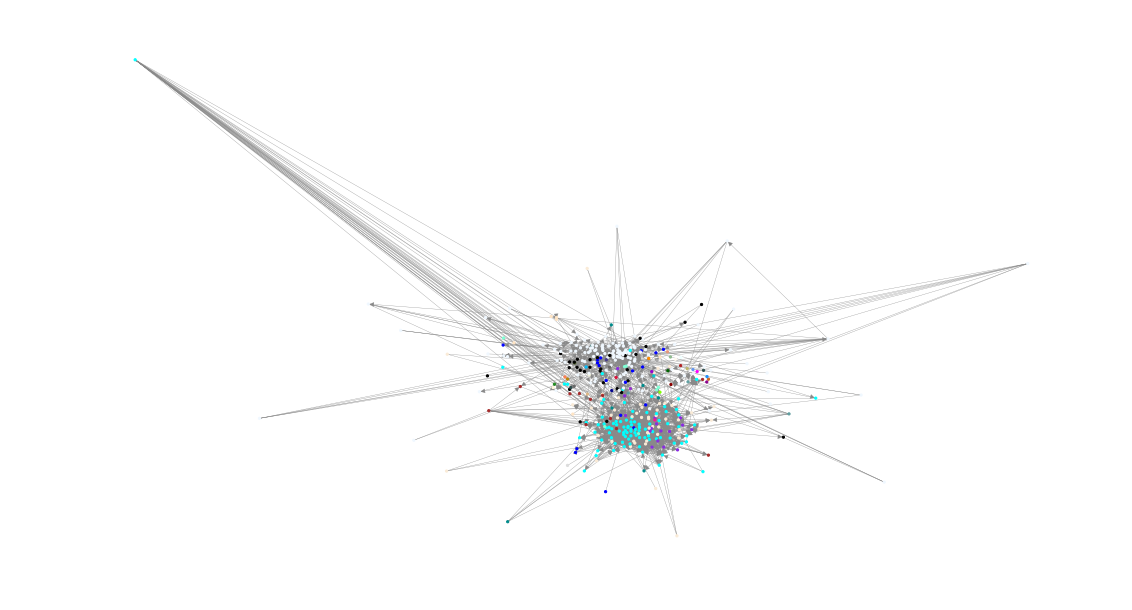

In [18]:
from matplotlib import colors as mcolors

plt.rcParams["figure.figsize"] = [15, 8];

#We create an array with the colors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
com_colors = []
for com in set(partition.values()):
    com_colors.append(list(mcolors.CSS4_COLORS)[com % len(list(mcolors.CSS4_COLORS)) ])


positions = forceatlas2.forceatlas2_networkx_layout(rt_graph,
                                                    pos=None,
                                                    iterations=6000)
      
node_colors = [com_colors[partition[node]] for node in rt_graph.nodes]

weights = {}
for u, v in rt_graph.edges:
    weights[(u, v)] = rt_graph[u][v]['weight']
    
nx.draw(rt_graph,
        positions,
        cmap=plt.get_cmap('jet'),
        node_size = 5,
        node_color = node_colors,
        border = 0.1,
        edge_color = "#898989",
        overlap = False,
        width = .3,
        with_labels=False)
plt.show()

- Compare the communities found by your algorithm with the parties by creating a matrix $\mathbf{D}$ with dimension $(B \times C$, where $B$ is the number of parties and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that party $i$ has in common with community $j$. The matrix $\mathbf{D}$ is what we call a confusion matrix.

In [19]:
parties = {(0, 'Republican'), (1, 'Democratic')}
communities = set(partition.values())

D = [[0 for j in range(len(communities))] for i in range(len(parties))]
for p, party in parties:
    for com in communities:
        nodes_ij = [n for n in rt_graph.nodes
                    if(rt_graph.node[n]['party'].item() == party
                       and partition[n] == com)]
        D[p][com] = len(nodes_ij)

- Plot the confusion matrix and explain how well the communities you've detected correspond to the parties. Consider the following questions:
    - Are there any republicans grouped with democrats (and vice versa)?
        - _There can be found some cases colored in a softer tone, although they are not as significant as communities of members from the same party._
    - Does the community detection algorithm sub-divide the parties? Do you know anything about American politics that could explain such sub-divisions? Answer in your own words.
       # todo
       - _It groups nodes by popularity (number of connections) regardless of the party they belong to. From our very little knowledge on American politics, there will be some communities populated by representatives that are independent (have more freedom to vote against their party, for instance). Their independance means their decisions make a smaller influence among others, therefore they will have less retweets._ 

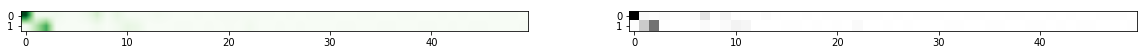

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

a = D

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(121)
# Bilinear interpolation - this will look blurry
ax1.imshow(a,
           interpolation='bilinear',
           cmap=cm.Greens)

ax2 = fig.add_subplot(122)
# 'nearest' interpolation - faithful but blocky
ax2.imshow(a,
           interpolation='nearest',
           cmap=cm.Greys)
plt.show()

<hr>

# <u> Part 2: What do republican and democratic members tweet about? </u>

### <i> Exercise 4: TF-IDF of the republican and democratic tweets. </i>

We will create two documents, one containing the words extracted from tweets of republican members, and the other for Democratic members. We will then use TF-IDF to compare the content of these two documents and create a word-cloud. The procedure you should use is exactly the same you used in exercise 2 of week 7. The main steps are summarized below:
- Create two large documents, one for the democratic and one for the republican party. Tokenize the pages, and combine the tokens into one long list including all the pages of the members of the same party.
    - Exclude all twitter handles.
    - Exclude punctuation.
    - Exclude stop words (if you don't know what stop words are, go back and read NLPP1e again).
    - Exclude numbers (since they're difficult to interpret in the word cloud).
    - Set everything to lower case.
    - Compute the TF-IDF for each document.

In [21]:
import nltk
from nltk.corpus import stopwords

for acc in rt_graph.nodes:
    
    f = io.open(path+acc, 'r', encoding='utf-8').read()
    
    #Remove Twitter handles
    words = nltk.word_tokenize(f)
    words = [w for w in words
             if not re.search(r"(RT)((?:\b\W@(\w+))+)|@|RT|http|amp", w)]
    words = [w.lower() for w in words]
    words = [w for w in words 
             if w not in stopwords.words('english')]
    words = [w for w in words
             if not re.search(r'[.,\/#!?$%\^&\*;:{}=\-\—_`´’~()\']', w)]
    words = [w for w in words
             if not re.search(r'\s|\d+(\.\d+)?', w)]
    
    #divide Republicans and Democrats
    if rt_graph.node[acc]['party'].item() == 'Republican':
        file = open("data/republicans.txt","w")
        file.write(" ".join(words))
    else:
        file = open("data/democrats.txt","w")
        file.write(" ".join(words))
    file.close()

- Now, create word-cloud for each party. Are these topics less "boring" than the wikipedia topics from a few weeks ago? Why? Comment on the results.
    - _The topics are more up-to-date thus Twitter is the main channel of communication used by politicians nowadays to keep the citizens informed. Wikipedia's words were related to general information of the members of the house, probably writen by a third person._
    
    _As a reminder, the words that appeared using Wikipedia as our source were district, committee, senate, ..._

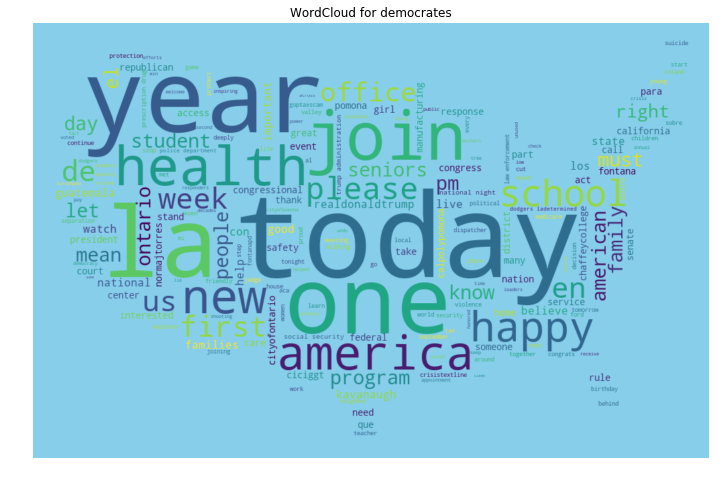

In [22]:
from wordcloud import WordCloud
import numpy as np
from PIL import Image
import requests

plt.rcParams["figure.figsize"] = [15, 8];

mask = np.array(Image.open(requests.get('http://imgur.com/9ezskNd.png', stream=True).raw))

dem = open("data/democrats.txt","r").read()
dem_words = nltk.word_tokenize(dem)
dem_text = nltk.Text(dem_words)

rep = open("data/republicans.txt","r").read()
rep_words = nltk.word_tokenize(rep)
rep_text = nltk.Text(rep_words)

def drawWordCloud(text):
    wordcloud = WordCloud(background_color="skyblue", mask=mask).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

drawWordCloud(dem)
plt.title("WordCloud for democrates");

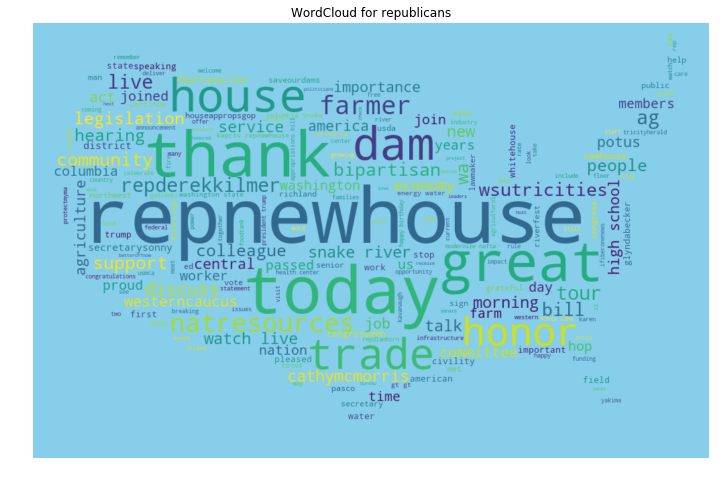

In [23]:
drawWordCloud(rep)
plt.title("WordCloud for republicans");

<hr>

# <u> Part 3: Sentiment analysis</u>

### <i> Exercise 5: Sentiment over the Twitter data. </i>

- Download the LabMT wordlist. It's available as supplementary material from Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Data Set S1). Describe briefly how the list was generated.
    - _The list was generated following by analysing words on a large number of Twitter users' feed, then conducting a survey of happinness evaluation of thousands of words._

In [24]:
labMT = pd.read_csv('data/s001.txt', sep="\t")

- Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).
    - _Our solution gives the average for each parameter. We calculate happiness average and standard deviation._

In [34]:
def calculate_sentiment(list_of_tokens):
    happiness_avg_sum = 0.
    happiness_std_dev_sum = 0.
    sentiment_words = 0.
    for token in list_of_tokens:
        if token in list(labMT.word) :
            happiness_avg_sum += float(labMT[labMT.word == token].happiness_average)
            happiness_std_dev_sum += float(labMT[labMT.word == token].happiness_standard_deviation)
            sentiment_words += 1.
    #print('Happiness points: ', happiness_points)
    #print('Sent words: ', sent_words)
    happiness_avg = happiness_avg_sum/sentiment_words if sentiment_words else 0
    happiness_std_dev = happiness_std_dev_sum/sentiment_words if sentiment_words else 0
    return (happiness_avg, happiness_std_dev)

In [35]:
calculate_sentiment(dem_words)

(5.646494623655924, 1.358765734767023)

- Create two lists: one including the tweets written by democratic members, and the other including the tweets written by republican members (in the text files, tweets are separated by newlines).

In [36]:
tweets_rep, tweets_dem = [], []
for file in os.listdir(path):
    tweets = io.open(path+file, 'r', encoding='utf-8').read().split('\n')
    if tw_parties[tw_parties.tw_name == file].Party.item() == 'Republican':
        tweets_rep.extend(tweets)
    else:
        tweets_dem.extend(tweets)

- Calculate the sentiment of each tweet and plot the distribution of sentiment for each of the two lists. Are there significant differences between the two? Which party post more positive tweets?

In [48]:
sentiment_rep = []
sentiment_rep = [calculate_sentiment(nltk.word_tokenize(tweet))
                 for tweet in tweets_rep]

In [ ]:
sentiment_dem = []
sentiment_dem = [calculate_sentiment(nltk.word_tokenize(tweet))
                 for tweet in tweets_dem]

In [28]:
sentiment_dem = []

for tweet in tweets_dem:
    sentiment_dem.append(calculate_sentiment(nltk.word_tokenize(tweet)))

- Compute the average m and standard deviation $\sigma$ of the tweets sentiment (considering tweets by both republican and democrats).

- Now consider only tweets with sentiment lower than m-2$\sigma$. We will refer to them as negative tweets. Build a list containing the negative tweets written by democrats, and one for republicans. Compute the TF-IDF for these two lists (use the same pre-processing steps in Exercise 5). Create a word-cloud for each of them. Comment on the differences between the negative contents posted by republicans and democrats.

- Repeat the point above, but considering positive tweets instead (e.g. with sentiment larger than m+2$\sigma$). Comment on your results.